In [1]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [2]:
%%capture output
pip install langgraph langchain langchain_openai

In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [4]:
model = ChatOpenAI(model='gpt-4o-mini')


In [5]:
class SentimentSchema(BaseModel):
  sentiment: Literal['positive','negative'] = Field(description = 'Sentiment of the review')

In [6]:
structured_model = model.with_structured_output(SentimentSchema)


In [7]:
prompt = 'What is the sentiment of the following review - The Food is not good'
structured_model.invoke(prompt).sentiment

'negative'

In [8]:
class ReviewState(TypedDict):
  review: str
  sentiment: Literal["positive", "negative"]
  diagnosis: dict
  response: str


In [10]:
def find_sentiment(state: ReviewState):
  prompt = f'Please find the sentiment of the following review \n {state["review"]}'
  sentiment = structured_model.invoke(prompt).sentiment
  return {'sentiment': sentiment}

In [15]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
  if state['sentiment'] == 'positive':
    return 'positive_response'
  else:
    return 'run_diagnosis'



In [17]:
def positive_response(state:ReviewState):
  prompt = f"""Write a warm thank you message in response to this revie: \n\n "{state['review']}"\n
  Also, Kindly ask the user to leave feedback on our website.

  """
  response = model.invoke(prompt).content
  return {'response': response}

In [18]:
class DiagnosisSchema(BaseModel):
  issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description = "The category of issue mentioned in the review")
  tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description = "The emotional tone expressed by the user")
  urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")

In [19]:
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [20]:
def run_diagnosis(state: ReviewState):
  prompt = f"""Diagnose this negative review: \n\n {state['review']}\n
  Return issue_type, tone and urgency.
  """
  response = structured_model2.invoke(prompt)
  return {'diagnosis': response.model_dump()}



In [22]:
def negative_response(state:ReviewState):
  diagnosis = state['diagnosis']
  prompt = f"""You are a support assistant. The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and market urgency level of {diagnosis['urgency']}\n Write an empathetic, helpful resolution message. """
  response = model.invoke(prompt).content
  return {'response': response}

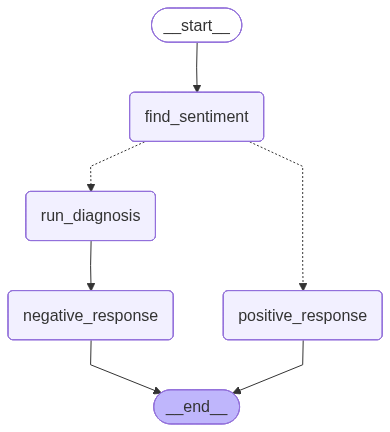

In [28]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response', END)

workflow= graph.compile()
workflow


In [31]:
initial_state = {
    'review': 'The movie was bad. Acting could have been better'
}

In [32]:
workflow.invoke(initial_state)

{'review': 'The movie was bad. Acting could have been better',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Other',
  'tone': 'disappointed',
  'urgency': 'low'},
 'response': "Subject: We're Here to Help\n\nHi [User's Name],\n\nI hope this message finds you well. I wanted to reach out regarding your recent experience. I understand that it didn’t meet your expectations, and I sincerely apologize for any disappointment this may have caused.\n\nWe value your feedback and are committed to making things right. If you could provide a bit more detail about the specific issue you encountered, I’d be more than happy to assist you further. Your satisfaction is important to us, and we want to ensure you have a positive experience moving forward.\n\nThank you for your patience, and I'm here to help!\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Contact Information]  "}